In [1]:
import sys
sys.path
sys.path.append('/home/mnt/nzh/nzhanglab/project/shuang/miniconda3/envs/scglue2/lib/python3.8/site-packages')


In [2]:
import anndata
import itertools
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns

from matplotlib import rcParams

In [3]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [4]:
rna = anndata.read_h5ad("e18mouse/rna_preprocessed_v2.h5ad")
atac = anndata.read_h5ad("e18mouse/atac_preprocessed_v2.h5ad")
graph = nx.read_graphml("e18mouse/prior_v2.graphml.gz")

In [5]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca"
)

In [6]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [7]:
graph = graph.subgraph(itertools.chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
))

In [8]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, graph,
    fit_kws={"directory": "e18mouse_glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] SCGLUEModel: Setting `graph_batch_size` = 25525
[INFO] SCGLUEModel: Setting `max_epochs` = 429
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "e18mouse_glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.583, 'g_kl': 0.005, 'g_elbo': 0.588, 'x_rna_nll': 0.567, 'x_rna_kl': 0.019, 'x_rna_elbo': 0.585, 'x_atac_nll': 0.27, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.272, 'dsc_loss': 0.668, 'vae_loss': 0.881, 'gen_loss': 0.847}, val={'g_nll': 0.583, 'g_kl': 0.005, 'g_elbo': 0.587, 'x_rna_nll': 0.579, 'x_rna_kl': 0.018, 'x_rna_elbo': 0.597, 'x_atac_nll': 0.271, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.273, 'dsc_loss': 0.666, 'vae_loss': 0.894, 'gen_loss': 0.86}, 2.3s elapsed
[INFO] SCGLUETrainer: [Epoch 20] train={'g_nll': 0.493, 'g_kl': 0.007, 'g_elbo': 0.501, 'x_rna_nll': 0.545, 'x_r

2022-06-28 16:19:51,852 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "148"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (22, 23)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 25525
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 429
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "e18mouse_glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.446, 'g_kl': 0.008, 'g_elbo': 0.453, 'x_rna_nll': 0.53, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.547, 'x_atac_nll': 0.247, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.248, 'dsc_loss': 0.683, 'vae_loss': 0.813, 'gen_loss': 0.779}, val={'g_nll': 0.44

Engine run is terminating due to exception: 


[INFO] SCGLUETrainer: Stopping training due to user interrupt...


In [12]:
glue.save("e18mouse_glue_v2.dill")

In [11]:
import os

os.getcwd()


'/home/mnt/nzh/nzhanglab/project/shuang/scATAC/comparison_methods/scglue'

In [13]:
glue = scglue.models.load_model("e18mouse_glue_v2.dill")

In [14]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, graph,
    count_layers={"rna": "counts"}
)
dx

[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 99 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 198 common metacells...


,n_meta,consistency
0,10,0.097572
1,20,0.077555
2,50,0.059488
3,100,0.058360
4,200,0.047918


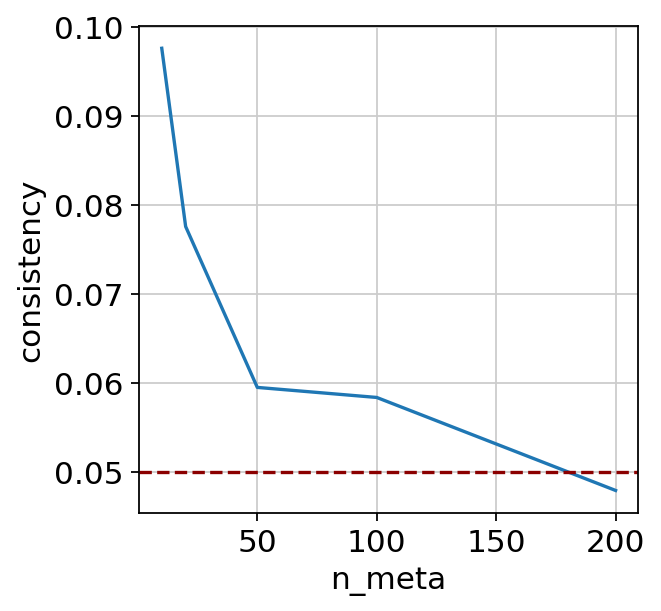

In [15]:
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")


In [16]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [17]:
import numpy
rna.obs_names = numpy.char.add("rna",rna.obs_names)

In [18]:
atac.obs_names = numpy.char.add("atac",atac.obs_names)

In [19]:
combined = anndata.concat([rna, atac])
combined.var_names_make_unique()


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/stat/shuang91/gpuenv385/lib/python3.8/site-packages/anndata/_core/anndata.py:898: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  names = self._prep_dim_index(names, "var")


In [20]:
rna

AnnData object with n_obs × n_vars = 3981 × 14361
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'celltype', 'domain', 'balancing_weight'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag'
    uns: 'celltype_colors', 'hvg', 'neighbors', 'pca', 'umap', '__scglue__'
    obsm: 'X_pca', 'X_umap', 'X_glue'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [21]:
atac

AnnData object with n_obs × n_vars = 3981 × 139083
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'celltype', 'domain', 'balancing_weight'
    var: 'features', 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'umap', '__scglue__'
    obsm: 'X_lsi', 'X_umap', 'X_glue'
    obsp: 'connectivities', 'distances'

/home/stat/shuang91/gpuenv385/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'domain' as categorical


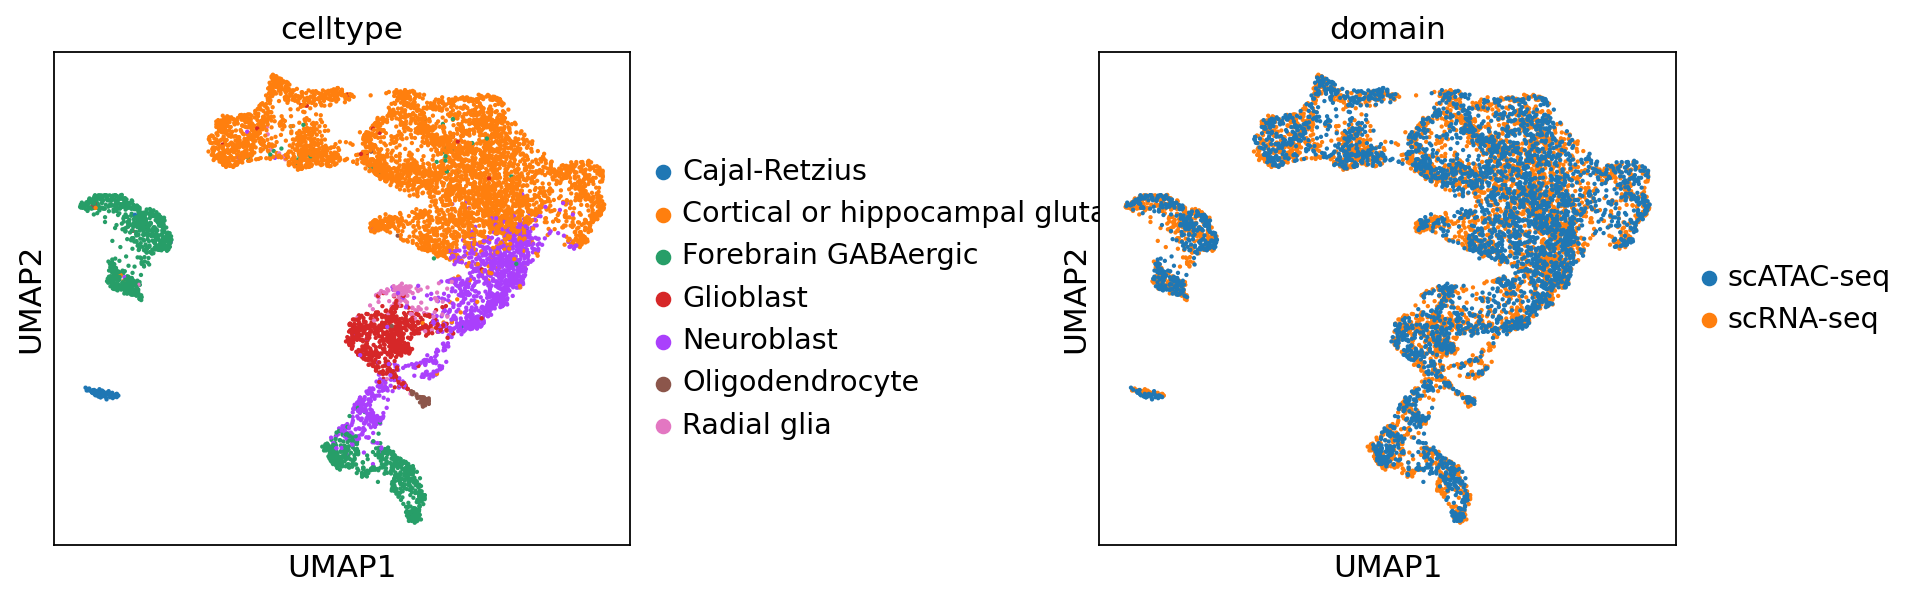

In [22]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["celltype", "domain"], wspace=0.65)

In [23]:
feature_embeddings = glue.encode_graph(graph)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

,0,1,2,3,4
0610040J01Rik,0.005741,-0.351602,0.005864,0.332498,0.312822
1500009L16Rik,-0.004729,0.243511,0.005015,0.192661,0.642996
1700007K13Rik,-0.005290,0.177551,0.010588,-0.194455,0.324102
1700016K19Rik,-0.003651,0.200549,0.011036,-0.069939,0.212507
1700019D03Rik,-0.003822,-0.245522,-0.002538,-0.228989,-0.091425


In [24]:
glue_array = combined.obsm['X_glue']

In [25]:
import numpy as np
glue_array = pd.DataFrame(glue_array)
glue_array.index = np.concatenate([rna.obs_names,atac.obs_names])

In [27]:
glue_array.to_csv('/home/mnt/nzh/nzhanglab/project/shuang/scATAC/comparison_methods/scglue/e18mouse_glue_embeddings_v2.csv', index=True)

In [26]:
glue_array.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7962 entries, rnaAAACAGCC to atacTTTGTTGG
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7962 non-null   float32
 1   1       7962 non-null   float32
 2   2       7962 non-null   float32
 3   3       7962 non-null   float32
 4   4       7962 non-null   float32
 5   5       7962 non-null   float32
 6   6       7962 non-null   float32
 7   7       7962 non-null   float32
 8   8       7962 non-null   float32
 9   9       7962 non-null   float32
 10  10      7962 non-null   float32
 11  11      7962 non-null   float32
 12  12      7962 non-null   float32
 13  13      7962 non-null   float32
 14  14      7962 non-null   float32
 15  15      7962 non-null   float32
 16  16      7962 non-null   float32
 17  17      7962 non-null   float32
 18  18      7962 non-null   float32
 19  19      7962 non-null   float32
 20  20      7962 non-null   float32
 21  21      7962 non-null   